In [1]:
from functions import *
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import shap
from collections import Counter

## Data Preprocessing

In [2]:
path_1 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem1.csv"
path_2 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem2.csv"
path_3 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem3.csv"
path_4 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem4.csv"

BHT_1 = pd.read_csv(path_1, sep=';')
BHT_2 = pd.read_csv(path_2, sep=',')
BHT_3 = pd.read_csv(path_3, sep=',')
BHT_4 = pd.read_csv(path_4, sep=',')

In [3]:
BHT_1 = BHT_1.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_2 = BHT_2.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_3 = BHT_3.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_4 = BHT_4.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})

In [4]:
BHT_1 = BHT_1[BHT_1['no_passed_courses_1']<=6]
BHT_2 = BHT_2[(BHT_2['no_passed_courses_2']<=12) & (BHT_2['no_passed_courses_1']<=6)]
BHT_3 = BHT_3[(BHT_3['no_passed_courses_2']<=12) & (BHT_3['no_passed_courses_1']<=6)]
BHT_4 = BHT_4[(BHT_4['no_passed_courses_2']<=12) & (BHT_4['no_passed_courses_1']<=6)]


In [5]:
### swaping values
# after swaping, '1' is -> 'dropout' & '0'a is ->'graduate'
BHT_1['status'] = BHT_1['status'].replace([0, 1], [1, 0])
BHT_2['status'] = BHT_2['status'].replace([0, 1], [1, 0])
BHT_3['status'] = BHT_3['status'].replace([0, 1], [1, 0])
BHT_4['status'] = BHT_4['status'].replace([0, 1], [1, 0])

In [6]:
features_bht1 = BHT_1.columns[1:-1]
features_bht2 = BHT_2.columns[1:-1]
features_bht3 = BHT_3.columns[1:-1]
features_bht4 = BHT_4.columns[1:-1]

### Search Space / Param Grid 

In [7]:
from hyperopt import *
search_space = {
    'n_estimators': hp.choice('n_estimators', list(range(5, 100, 5))),  # Number of boosting rounds
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.8),  # Step size shrinkage
    'booster': hp.choice('booster', ['gbtree']),
    'max_depth': hp.choice('max_depth', list(range(4, 12))),  # Tree depth
    'subsample': hp.uniform('subsample', 0.4, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.1),  # L2 regularization term on weights
    'min_child_weight': hp.uniform('min_child_weight', 0.1, 2),  # Minimum sum of instance weight in a child
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1 , 2.5),  # Balancing class weights for imbalanced dat
}


## BHT semester 1

In [8]:
hpo = ModelTrainer(random_state=42)

# Count occurrences of each unique value in the 'status' column
counter_1 = Counter(BHT_1['status'])
print(f'Quantity of Drop Out and Degree in THL-1: \n 1: {counter_1[1]} | 0: {counter_1[0]}')
x, y = hpo.split_data(BHT_1, features_bht1)

Quantity of Drop Out and Degree in THL-1: 
 1: 160 | 0: 96


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:04<00:00,  2.22trial/s, best loss: -0.7282371794871795]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            07               13
	 actual 1            09               23

Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9690957863664406, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.4422492215531373, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': 0.7242794519507014, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': 0.054889874318505075, '

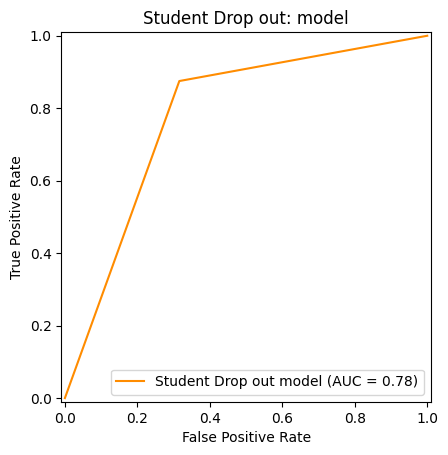

In [9]:
hpo = ModelTrainer(random_state=42)
model, feature_importance = hpo.cross_validation_hpo(
    x=x, y=y,
    search_space=search_space, 
    folds=5,
    algo='xgb'
    )

In [10]:
feature_importance

,Feature,Importance
2,no_of_unattempted_courses_1,0.448492
0,no_passed_courses_1,0.222857
1,no_of_failed_courses_1,0.195603
3,avg_grade_all_courses_1,0.133048


#### Shap analysis

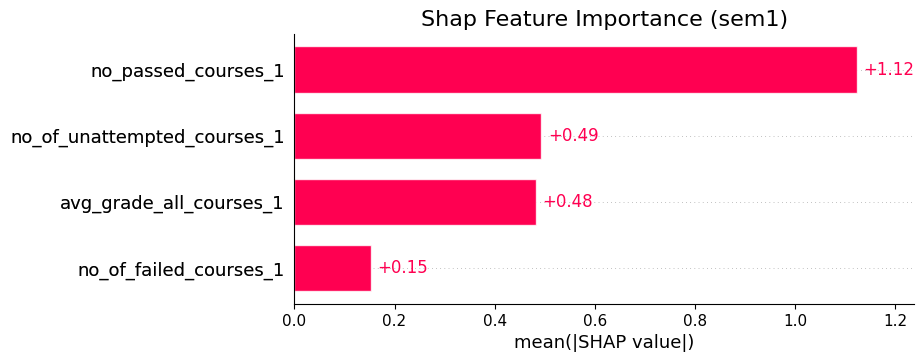

In [13]:
## Shap Global explainations
import shap
explainer = shap.Explainer(model['model'], model['x_train'])
shap_values = explainer(model['x_test'])

plt.title('Shap Feature Importance (sem1)', fontsize=16)
shap.plots.bar(shap_values)

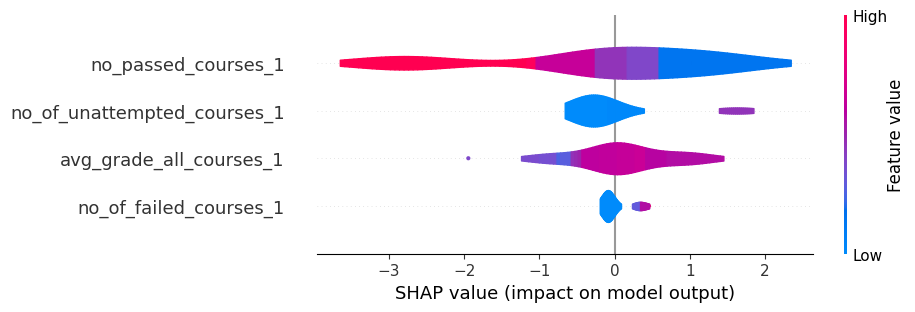

In [14]:
shap.plots.violin(shap_values, show=True)

In [15]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values, link='logit')

In [16]:
hpo.plot_shap_force(model=model, shap_values=shap_values, student_index=11, model_name='lr')

Student index 11 grades:
                             grades
no_passed_courses_1             5.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.2
Status: 0, Prediction: [1], Probability [0]: 0.260, Probability [1]: 0.740


In [17]:
hpo.plot_shap_force(model=model, shap_values=shap_values, student_index=12, model_name='lr')

Student index 12 grades:
                             grades
no_passed_courses_1             2.0
no_of_failed_courses_1          3.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         4.2
Status: 1, Prediction: [1], Probability [0]: 0.165, Probability [1]: 0.835


In [18]:
hpo.plot_shap_force(model=model, shap_values=shap_values, student_index=39, model_name='lr')

Student index 39 grades:
                             grades
no_passed_courses_1             0.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     4.0
avg_grade_all_courses_1         0.0
Status: 1, Prediction: [1], Probability [0]: 0.025, Probability [1]: 0.975


In [19]:
hpo.plot_shap_force(model=model, shap_values=shap_values, student_index=46, model_name='lr')

Student index 46 grades:
                             grades
no_passed_courses_1             0.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     3.0
avg_grade_all_courses_1         5.0
Status: 1, Prediction: [1], Probability [0]: 0.014, Probability [1]: 0.986


## BHT semester 2 

In [20]:
# Count occurrences of each unique value in the 'status' column
counter_2 = Counter(BHT_2['status'])
print(f'Quantity of Drop Out and Degree in THL-2: \n 1: {counter_2[1]} | 0: {counter_2[0]}')
hpo2 = ModelTrainer(random_state=69)
x2, y2 = hpo2.split_data(BHT_2, features_bht2)

Quantity of Drop Out and Degree in THL-2: 
 1: 102 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:03<00:00,  3.03trial/s, best loss: -0.8497549019607844]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            14               05
	 actual 1            07               14

Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9754466759000084, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.03911204682965026, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1.8563016774407064, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 69, 'reg_alpha': None, 'reg_lambda': 0.06757257809444761, '

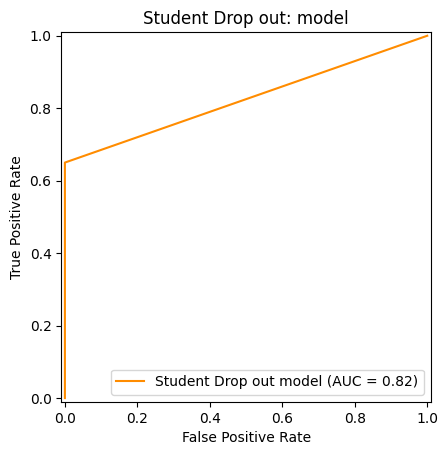

In [22]:
model_2, feature_importance_2 = hpo2.cross_validation_hpo(
    x=x2, y=y2,
    search_space=search_space, 
    folds=5,
    algo='xgb'
    )

In [23]:
feature_importance_2

,Feature,Importance
3,avg_grade_all_courses_2,0.191629
0,no_passed_courses_2,0.184586
2,no_of_unattempted_courses_2,0.172548
4,no_passed_courses_1,0.139593
7,avg_grade_all_courses_1,0.128548
5,no_of_failed_courses_1,0.097990
1,no_of_failed_courses_2,0.085106
6,no_of_unattempted_courses_1,0.000000


#### Shap analysis

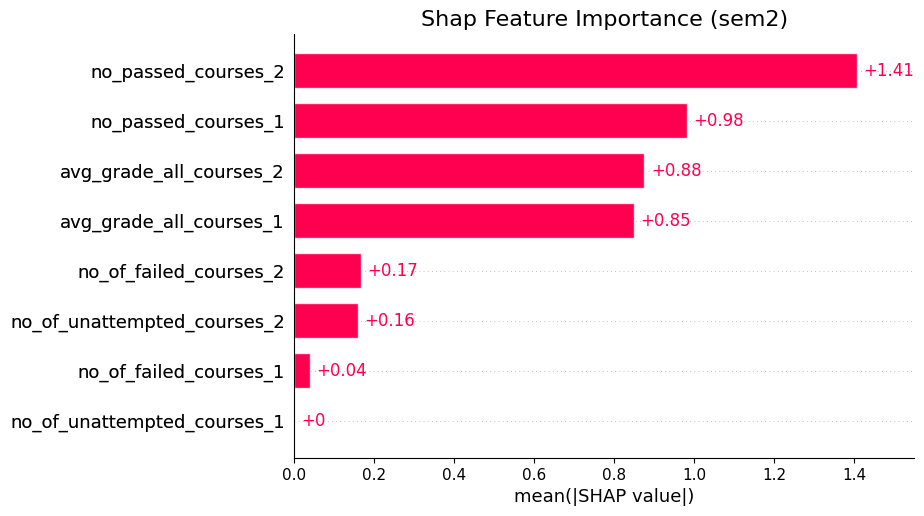

In [24]:
## Shap Global explainations
import shap
explainer2 = shap.Explainer(model_2['model'], model_2['x_train'])
shap_values2 = explainer2(model_2['x_test'])

plt.title('Shap Feature Importance (sem2)', fontsize=16)
shap.plots.bar(shap_values2)

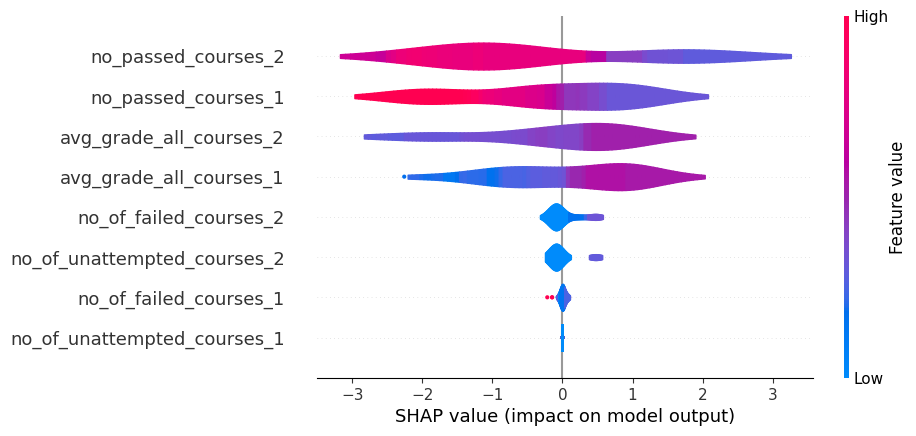

In [25]:
shap.plots.violin(shap_values2, show=True)

In [26]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values2, link='logit')

In [27]:
hpo2.plot_shap_force(model=model_2, shap_values=shap_values2, student_index=20, model_name='lr')

Student index 20 grades:
                             grades
no_passed_courses_2             4.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.9
no_passed_courses_1             5.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.1
Status: 0, Prediction: [0], Probability [0]: 0.965, Probability [1]: 0.035


In [28]:
hpo2.plot_shap_force(model=model_2, shap_values=shap_values2, student_index=5, model_name='lr')

Student index 5 grades:
                             grades
no_passed_courses_2             3.0
no_of_failed_courses_2          1.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.5
no_passed_courses_1             3.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.8
Status: 1, Prediction: [0], Probability [0]: 0.951, Probability [1]: 0.049


In [29]:
hpo2.plot_shap_force(model=model_2, shap_values=shap_values2, student_index=6, model_name='lr')

Student index 6 grades:
                             grades
no_passed_courses_2             0.0
no_of_failed_courses_2          2.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         5.0
no_passed_courses_1             2.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.2
Status: 1, Prediction: [1], Probability [0]: 0.043, Probability [1]: 0.957


In [30]:
hpo2.plot_shap_force(model=model_2, shap_values=shap_values2, student_index=10, model_name='lr')

Student index 10 grades:
                             grades
no_passed_courses_2             6.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.0
no_passed_courses_1             6.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.5
Status: 0, Prediction: [0], Probability [0]: 0.965, Probability [1]: 0.035


## BHT semester 3

In [31]:
# Count occurrences of each unique value in the 'status' column
counter_3 = Counter(BHT_3['status'])
print(f'Quantity of Drop Out and Degree in THL-1: \n 1: {counter_3[1]} | 0: {counter_3[0]}')
# Count occurrences of each unique value in the 'status' column
hpo3 = ModelTrainer(random_state=42)
x3, y3 = hpo3.split_data(BHT_3, features_bht3)

Quantity of Drop Out and Degree in THL-1: 
 1: 71 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:02<00:00,  3.90trial/s, best loss: -0.8745454545454546]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            18               01
	 actual 1            05               10

Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.47221177322406777, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.5994652836748948, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': 0.8797573445833581, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': 0.08953788515130894, '

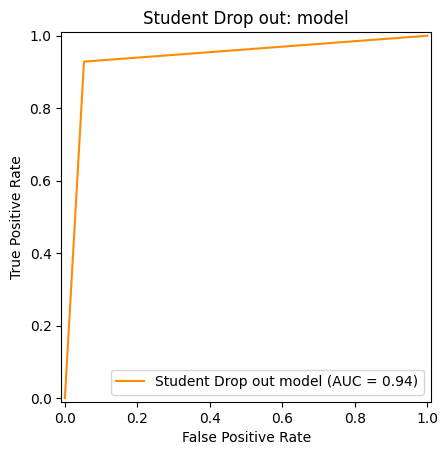

In [36]:
model_3, feature_importance_3 = hpo3.cross_validation_hpo(
    x=x3, y=y3,
    search_space=search_space, 
    folds=5,
    algo='xgb'
    )

In [37]:
feature_importance_3

,Feature,Importance
0,no_passed_courses_3,0.205039
6,no_of_unattempted_courses_2,0.195300
2,no_of_unattempted_courses_3,0.194161
4,no_passed_courses_2,0.129241
5,no_of_failed_courses_2,0.082637
7,avg_grade_all_courses_2,0.053116
11,avg_grade_all_courses_1,0.041618
8,no_passed_courses_1,0.034420
9,no_of_failed_courses_1,0.028122
3,avg_grade_all_courses_3,0.021291


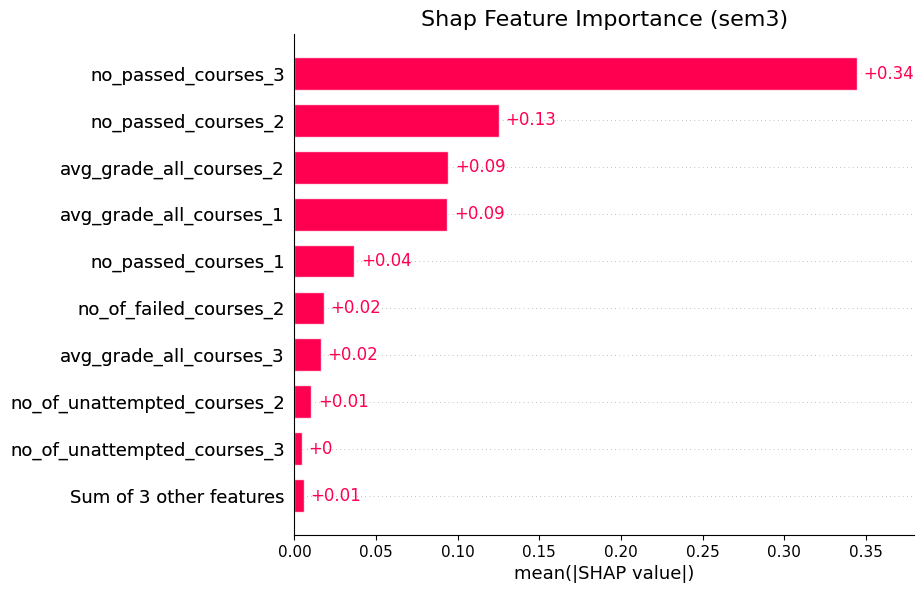

In [38]:
## Shap Global explainations
import shap
explainer3 = shap.Explainer(model_3['model'], model_3['x_train'])
shap_values3 = explainer3(model_3['x_test'])

plt.title('Shap Feature Importance (sem3)', fontsize=16)
shap.plots.bar(shap_values3)

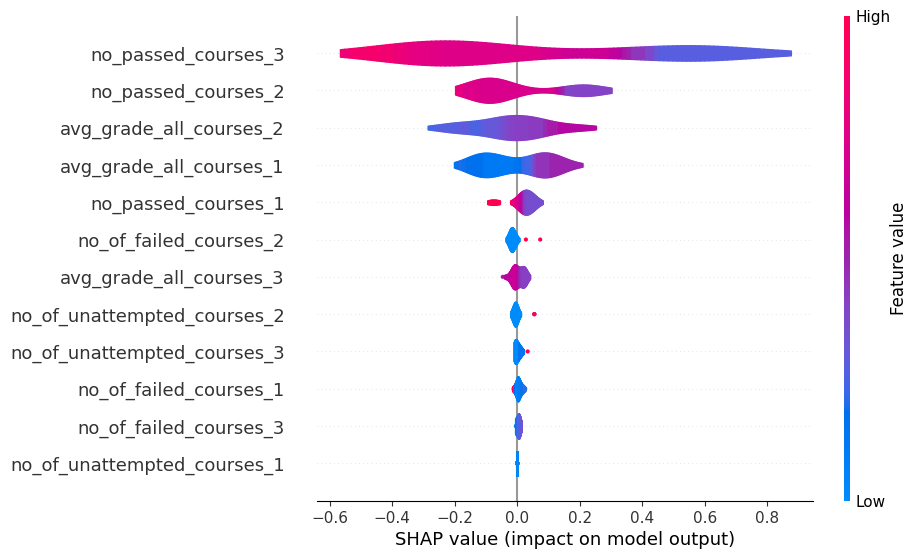

In [39]:
shap.plots.violin(shap_values3, show=True)

In [40]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values3, link='logit')

In [41]:
hpo3.plot_shap_force(model=model_3, shap_values=shap_values3, student_index=1, model_name='lr')

Student index 1 grades:
                             grades
no_passed_courses_3             3.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         1.6
no_passed_courses_2             7.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.3
no_passed_courses_1             1.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.0
Status: 0, Prediction: [0], Probability [0]: 0.653, Probability [1]: 0.347


In [42]:
hpo3.plot_shap_force(model=model_3, shap_values=shap_values3, student_index=9, model_name='lr')

Student index 9 grades:
                             grades
no_passed_courses_3             5.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         2.3
no_passed_courses_2             3.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.6
no_passed_courses_1             2.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.5
Status: 0, Prediction: [0], Probability [0]: 0.599, Probability [1]: 0.401


In [43]:
hpo3.plot_shap_force(model=model_3, shap_values=shap_values3, student_index=3, model_name='lr')

Student index 3 grades:
                             grades
no_passed_courses_3             4.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         2.8
no_passed_courses_2             4.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.3
no_passed_courses_1             4.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.0
Status: 0, Prediction: [0], Probability [0]: 0.635, Probability [1]: 0.365


In [44]:
hpo3.plot_shap_force(model=model_3, shap_values=shap_values3, student_index=10, model_name='lr')

Student index 10 grades:
                             grades
no_passed_courses_3             0.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     1.0
avg_grade_all_courses_3         0.0
no_passed_courses_2             2.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.7
no_passed_courses_1             3.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.5
Status: 1, Prediction: [1], Probability [0]: 0.344, Probability [1]: 0.656


## BHT semester 4

In [45]:
# Count occurrences of each unique value in the 'status' column
counter_4 = Counter(BHT_4['status'])
print(f'Quantity of Drop Out and Degree in THL-4: \n 1: {counter_4[1]} | 0: {counter_4[0]}')
# Count occurrences of each unique value in the 'status' column
hpo4 = ModelTrainer(random_state=42)
x4, y4 = hpo4.split_data(BHT_4, features_bht4)


Quantity of Drop Out and Degree in THL-4: 
 1: 59 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:02<00:00,  3.70trial/s, best loss: -0.8419444444444444]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            16               03
	 actual 1            05               07

Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9228586897173029, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.053415668715504745, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 0.15855306133899552, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': 0.06507356577033759,

,Feature,Importance
3,avg_grade_all_courses_4,0.241570
0,no_passed_courses_4,0.194167
4,no_passed_courses_3,0.126994
11,avg_grade_all_courses_2,0.118769
8,no_passed_courses_2,0.117878
7,avg_grade_all_courses_3,0.081085
12,no_passed_courses_1,0.066844
15,avg_grade_all_courses_1,0.052694
1,no_of_failed_courses_4,0.000000
2,no_of_unattempted_courses_4,0.000000


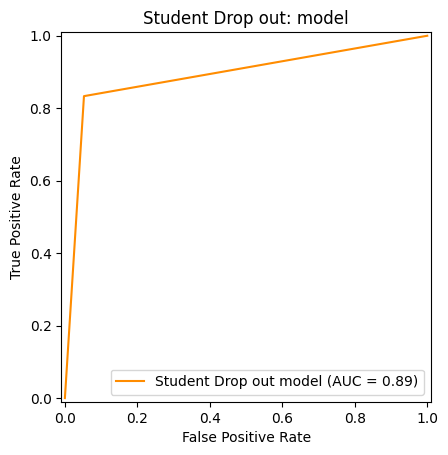

In [48]:
model_4, feature_importance_4 = hpo4.cross_validation_hpo(
    x=x4, y=y4,
    search_space=search_space, 
    folds=5,
    algo='xgb'
    )
feature_importance_4

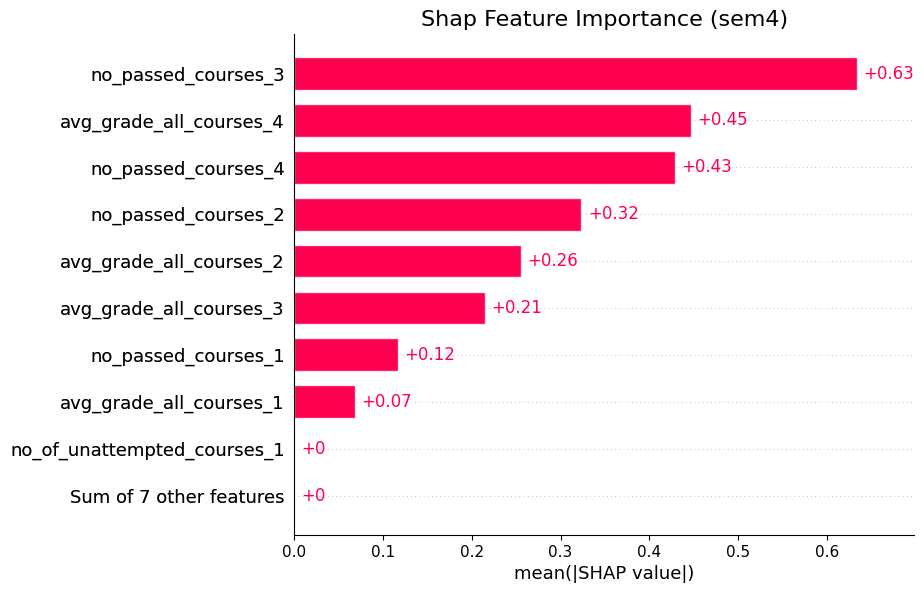

In [49]:
# Shap Global explainations
import shap
explainer4 = shap.Explainer(model_4['model'], model_4['x_train'])
shap_values4 = explainer4(model_4['x_test'])

plt.title('Shap Feature Importance (sem4)', fontsize=16)
shap.plots.bar(shap_values4)

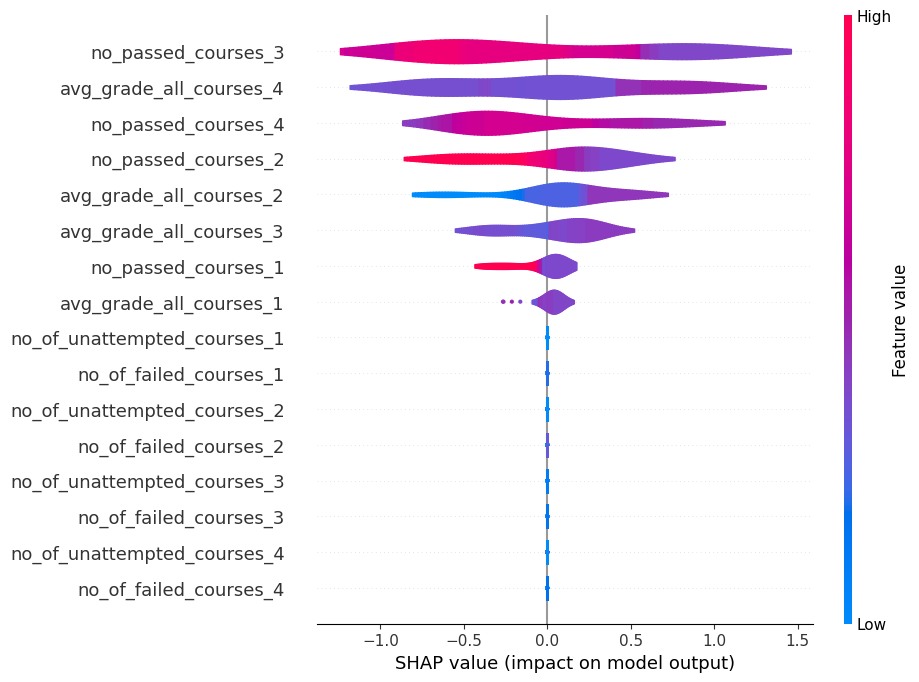

In [50]:
shap.plots.violin(shap_values4, show=True)

In [51]:
# Local explainations
shap.initjs()
shap.force_plot(shap_values4, link='logit')

In [52]:
hpo4.plot_shap_force(model=model_4, shap_values=shap_values4, student_index=1, model_name='lr')

Student index 1 grades:
                             grades
no_passed_courses_4             0.0
no_of_failed_courses_4          3.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         5.0
no_passed_courses_3             0.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         5.1
no_passed_courses_2             0.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         5.1
no_passed_courses_1             0.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         5.1
Status: 1, Prediction: [1], Probability [0]: 0.050, Probability [1]: 0.950


In [53]:
hpo4.plot_shap_force(model=model_4, shap_values=shap_values4, student_index=10, model_name='lr')


Student index 10 grades:
                             grades
no_passed_courses_4             6.0
no_of_failed_courses_4          0.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         2.5
no_passed_courses_3             5.0
no_of_failed_courses_3          1.0
no_of_unattempted_courses_3     1.0
avg_grade_all_courses_3         3.3
no_passed_courses_2             6.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.0
no_passed_courses_1             5.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.8
Status: 0, Prediction: [0], Probability [0]: 0.821, Probability [1]: 0.179


In [54]:
hpo4.plot_shap_force(model=model_4, shap_values=shap_values4, student_index=19, model_name='lr')


Student index 19 grades:
                             grades
no_passed_courses_4             3.0
no_of_failed_courses_4          2.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         3.4
no_passed_courses_3             2.0
no_of_failed_courses_3          1.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         3.8
no_passed_courses_2             3.0
no_of_failed_courses_2          1.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.4
no_passed_courses_1             4.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.3
Status: 1, Prediction: [1], Probability [0]: 0.290, Probability [1]: 0.710
